In [58]:
pip install pytictoc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV

In [32]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Metrics**

In [33]:
import mne
import pandas as pd
import numpy as np

def read_csv(eeg_csv, channels, sfreq = 256, montage = 'standard_1020', useless_cols = ['timestamp', 'sequence', 'battery', 'flags']):
  df = pd.read_csv(eeg_csv)
  df_mne = df.drop(useless_cols, axis=1)

  # Transpose the matrix because MNE expects it like that
  data_mne = df_mne.to_numpy().transpose()

  # Scale the data
  # data_mne = data_mne / 1000000

  # Create MNE Raw's Info object
  info_mne = mne.create_info(
      #ch_names=list(df_mne.columns),
      ch_names=channels,
      ch_types='eeg',
      sfreq=sfreq)

  bbt_raw = mne.io.RawArray(data_mne, info_mne)
  ten_twenty_montage = mne.channels.make_standard_montage(montage)

  raw = bbt_raw.copy().set_montage(ten_twenty_montage)
  return raw

In [34]:
import numpy as np

def filters(raw, fmin = 0.5, fmax = 100., notch = 50., sampling_rate = 250, fir_design = 'firwin'):

    '''Apply high/low-pass and notch filters:

        === Args ===
        * raw - mne Raw object: object to apply filters on
        * fmin, fmax - float: bandpass frequencies
        * notch - float: powerline (AC current) frequecy
        * ny_freq - float: Nyquist frequency. Half of the sampling rate
        * fir_design: str: Notch filter type. See mne doc for more details
        * sampling_rate - int, float: sampling rate of the measured data

        === Returns ===
        * raw_c - mne Raw object: Processed Raw copy
        '''
    raw_c = raw.copy()
    raw_c.filter(l_freq = fmin, h_freq = fmax)
    raw_c.notch_filter(np.arange(notch, sampling_rate/2, notch), fir_design=fir_design)
    return raw_c

from math import floor

def windowfy_dataset(dataframe, chunk_size=100, n_channels=16):
    n_chunks = floor(dataframe.shape[0] / chunk_size)

    windows = np.ndarray(shape=(n_chunks, chunk_size, n_channels), dtype=float)

    channels_array = []
    for i in range(1, n_channels + 1):
        channels_array.append("EEG-ch" + str(i))

    dataframe_as_pd = dataframe[channels_array].to_numpy()
    # shape --> (samplesChannel, nChannels)

    for iChunk in range(n_chunks):
        for iSample in range(chunk_size):
            idf = (iChunk * chunk_size) + iSample
            windows[iChunk][iSample] = dataframe_as_pd[idf]

    return windows

In [35]:
def signal_df_to_np(dataframe, chunk_size=100, n_channels=16):
    n_chunks = floor(dataframe.shape[0] / chunk_size)

    windows = np.ndarray(shape=(n_channels, n_chunks, chunk_size), dtype=float)

    channels_array = []
    for i in range(1, n_channels + 1):
        channels_array.append("EEG-ch" + str(i))

    channels_as_pd = dataframe[channels_array].to_numpy()
    # shape --> (samplesChannel, nChannels)

    for iChannel in range(n_channels):
        for iChunk in range(n_chunks):
            for iSample in range(chunk_size):
                idf = (iChunk * chunk_size) + iSample
                windows[iChannel][iChunk][iSample] = channels_as_pd[idf][iChannel]

    # shape --> (channels, windows, samples)
    return windows


def channels_to_list_df(channels_data, artifact_label):
    # shape --> (channels, windows, samples)

    channels_list_df = []

    for channelData in channels_data:
        channel_data_map = {'label': []}

        for iWindow, window in enumerate(channelData):
            even = (iWindow % 2) == 0
            label = artifact_label if (even and iWindow != 0) else "pause"
            channel_data_map['label'].append(label)

            for iSample, sample in enumerate(window):
                if iSample in channel_data_map:
                    channel_data_map[iSample].append(sample)
                else:
                    channel_data_map[iSample] = [sample]

        channel_data_df = pd.DataFrame(channel_data_map)
        channels_list_df.append(channel_data_df)
        # df.columns = ['window', 'label']

    # array --> df(window, sample) + last column label
    return channels_list_df

### Load Data

In [60]:
import pandas as pd

eeg_jaw_file = "EEG_jaw.csv"

eeg_LeftEye_file = "EEG_LeftEye.csv"
#eeg_RightEye_file = "EEG_RightEye.csv"

#eeg_LeftArm_file = "EEG_LeftEye.csv"
eeg_RightArm_file = "EEG_RightEye.csv"

df_jaw = pd.read_csv(eeg_jaw_file)
df_jaw.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,2013207674,34084,-2,0,-2381.923995,-445.118685,-4574.786316,-5639.386782,-1871.841976,-5884.614544,13176.009523,13981.863916,-5935.146989,-8995.687770,14347.430200,2239.063066,-10279.197270,9042.436062,-3567.142839,15623.626913
1,2013207674,34084,-2,0,-2388.445880,-449.523391,-4595.787761,-5649.364293,-1929.310008,-5903.778666,13170.400215,13977.374036,-5956.695980,-9001.236240,14341.638376,2235.692614,-10317.355167,9039.016939,-3570.926993,15621.339386
2,2013207674,34084,-2,0,-2390.538724,-449.742410,-4615.548100,-5655.874011,-2007.998504,-5931.873878,13165.715652,13974.307776,-6001.643452,-9002.513848,14338.438272,2233.891795,-10357.715417,9033.906506,-3573.445706,15621.388057
3,2013207674,34084,-2,0,-2389.845165,-449.280037,-4609.950960,-5655.484645,-2006.441038,-5933.200157,13163.282112,13973.103174,-6010.197343,-9001.662110,14334.678453,2232.881876,-10350.499973,9030.195359,-3576.390289,15619.368219
4,2013207674,34084,-2,0,-2389.638314,-447.272368,-4588.438472,-5652.235870,-1946.721982,-5914.753929,13165.946838,13976.558800,-5980.544665,-8999.617937,14332.427429,2233.441590,-10312.792281,9027.116931,-3578.020760,15618.492145


In [61]:
df_LeftEye = pd.read_csv(eeg_LeftEye_file)
df_LeftEye.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,158394385384,9429,-2,0,-3215.934438,-10335.180843,26123.643545,-9618.819860,11085.733054,1507.005755,13966.848978,21672.821724,-8617.126387,-9932.636929,8806.273234,2042.323576,-14867.246375,7685.689195,-16746.985187,-4164.856610
1,158394385384,9429,-2,0,-3229.902954,-10339.062338,26109.735867,-9624.076305,11084.467613,1506.227022,13966.216258,21671.239923,-8615.641928,-9932.344904,8809.193481,2044.063557,-14864.703327,7692.235416,-16742.714325,-4160.099041
2,158394385384,9429,-2,0,-3228.528004,-10337.602215,26105.099975,-9620.170475,11088.762810,1509.743486,13969.927406,21674.975406,-8612.113296,-9928.074043,8812.758616,2048.930636,-14860.529807,7698.951985,-16735.717900,-4155.025111
3,158394385384,9429,-2,0,-3212.588321,-10330.861311,26115.673703,-9609.462901,11093.836740,1516.277540,13975.366366,21679.027249,-8607.075869,-9922.549908,8815.776205,2053.347510,-14857.743404,7700.850145,-16731.495709,-4153.406807
4,158394385384,9429,-2,0,-3203.754573,-10331.250677,26131.199685,-9603.780587,11093.727231,1518.151365,13978.566470,21681.947497,-8608.170962,-9923.158293,8815.289497,2053.603031,-14858.984509,7695.922228,-16738.930172,-4157.641166


### Loading Data with BBT to operate on Frequency

In [62]:
raw_jaw = read_csv(eeg_jaw_file,
                        ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz'])

raw_LeftEye= read_csv(eeg_LeftEye_file,
                        ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz'])

Creating RawArray with float64 data, n_channels=16, n_times=41664
    Range : 0 ... 41663 =      0.000 ...   162.746 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=20608
    Range : 0 ... 20607 =      0.000 ...    80.496 secs
Ready.


Effective window size : 8.000 (s)


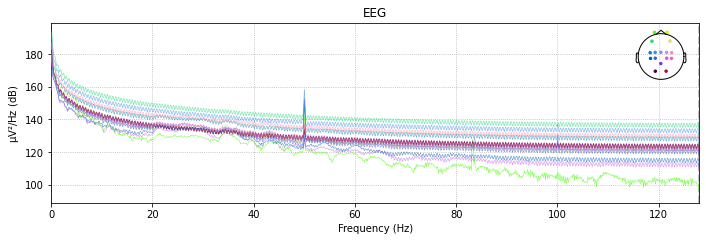

Effective window size : 8.000 (s)


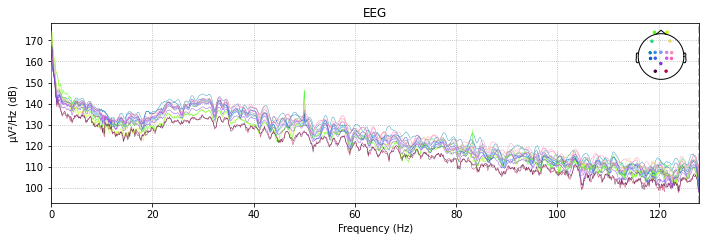

In [63]:
plot_raw = raw_jaw.plot_psd(fmin = 0, fmax = 128, average=False, tmin = 0, tmax = 120)
#plot_raw = raw_rubert.plot_psd(fmin = 0, fmax = 128, average=True, tmin = 0, tmax = 120)
#plot_raw = raw_rubert.plot_psd()
plot_raw = raw_LeftEye.plot_psd(fmin = 0, fmax = 128, average=False, tmin = 0, tmax = 120)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 sec)

Effective window size : 8.000 (s)


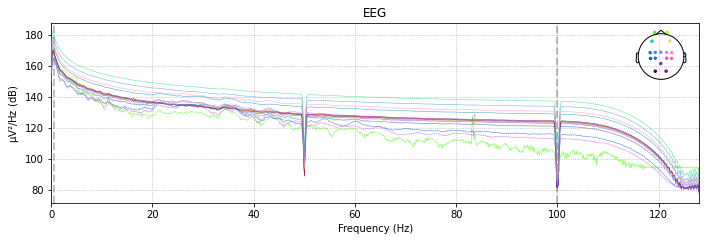

In [40]:
filtered_rubert = filters(raw_rubert)
plot_filtered = filtered_rubert.plot_psd(fmin = 0, fmax = 128, average=False, tmin = 0, tmax = 120)

In [64]:
save_path = '/content/pickle'

df_jaw.to_pickle(save_path + 'raw_jaw_1.pkl')
df_LeftEye.to_pickle(save_path + 'raw_LeftEye_1.pkl')

### Slicing into smaller temporal windows

In [65]:
sampling_rate = 256
window_time = 5 # segs
window_size = window_time * sampling_rate
n_channels = 16

windows_jaw = signal_df_to_np(df_jaw, window_size, n_channels)

windows_LeftEye = signal_df_to_np(df_LeftEye, window_size, n_channels)

print("---SHAPE---")
print(windows.shape)
print("---DATA---")
print(windows[0])

---SHAPE---
(16, 32, 1280)
---DATA---
[[-2381.92399467 -2388.44588016 -2390.53872402 ... -2463.69091732
  -2462.27946448 -2452.37495927]
 [-2449.73456906 -2446.48579401 -2444.87965803 ... -2535.12746536
  -2530.94177766 -2532.62091982]
 [-2538.18155727 -2535.61417324 -2526.79259304 ... -2527.23063013
  -2522.04719128 -2525.73400342]
 ...
 [-3821.94657827 -3814.5486186  -3797.75719698 ... -3565.84089554
  -3562.59212049 -3581.11135505]
 [-3593.74142435 -3592.37864231 -3586.78150177 ... -3662.14821589
  -3659.33747793 -3667.53850558]
 [-3675.19198689 -3677.40650771 -3669.49750477 ... -3375.37993717
  -3386.16051655 -3403.18312441]]


### Labeling data

New 


In [70]:
channels_list_df_jaw = channels_to_list_df(windows_jaw, 'jaw')

channels_list_df_LeftEye = channels_to_list_df(windows_LeftEye, 'lefteye')

channel = channels_list_df_jaw[0]
channel.head()

,label,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,pause,-2381.923995,-2388.445880,-2390.538724,-2389.845165,-2389.638314,-2388.336371,-2392.023183,-2395.430138,-2392.935760,...,-2462.766172,-2465.297053,-2461.135701,-2453.226698,-2453.421381,-2454.540809,-2459.444391,-2463.690917,-2462.279464,-2452.374959
1,pause,-2449.734569,-2446.485794,-2444.879658,-2443.954913,-2444.125261,-2444.478124,-2448.688147,-2451.365040,-2453.883754,...,-2535.772353,-2540.980128,-2538.145054,-2533.570000,-2532.961615,-2534.008037,-2535.602006,-2535.127465,-2530.941778,-2532.620920
2,jaw,-2538.181557,-2535.614173,-2526.792593,-2520.270708,-2520.927763,-2526.999444,-2532.985951,-2529.931859,-2524.383389,...,-2534.105379,-2530.613250,-2528.678586,-2533.667342,-2536.806608,-2536.928284,-2533.789019,-2527.230630,-2522.047191,-2525.734003
3,pause,-2533.010286,-2537.402825,-2532.815603,-2525.344637,-2519.272956,-2521.852508,-2527.449649,-2527.546990,-2524.930935,...,-2477.160558,-2472.731516,-2466.915357,-2466.124457,-2468.497158,-2476.016794,-2479.691439,-2468.107791,-2461.427726,-2469.020369
4,jaw,-2481.212401,-2481.224568,-2473.717099,-2466.404314,-2465.540407,-2469.470573,-2470.650840,-2463.508402,-2462.048278,...,-2515.513138,-2513.262114,-2509.806488,-2509.295445,-2511.412624,-2514.405878,-2511.071929,-2509.161600,-2511.011090,-2513.967841


In [71]:
for channel_df in channels_list_df_jaw:
    channel_df['label'] = channel_df['label'].replace({'pause': 0, 'jaw': 1})

channel = channels_list_df[0]
channel.head()


,label,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,pause,-3215.934438,-3229.902954,-3228.528004,-3212.588321,-3203.754573,-3213.367054,-3228.515837,-3232.811033,-3216.676668,...,-3017.175110,-3030.170211,-3027.420311,-3011.529299,-3003.084917,-3011.748318,-3031.021949,-3038.359071,-3027.322970,-3012.965087
1,pause,-3018.258035,-3027.371640,-3029.707838,-3020.204867,-3009.424288,-3015.544639,-3032.141377,-3035.414488,-3022.881760,...,-2742.732709,-2758.234354,-2762.347036,-2754.632716,-2744.290174,-2748.999072,-2761.203272,-2760.010838,-2744.399683,-2730.808366
2,lefteye,-2730.370329,-2745.762465,-2756.397032,-2748.256843,-2733.193234,-2737.123400,-2750.301016,-2758.575050,-2757.285274,...,-2451.060848,-2467.414233,-2469.494909,-2451.097351,-2436.118916,-2445.001335,-2461.050527,-2466.440817,-2455.514225,-2443.541211
3,pause,-2446.108595,-2461.269546,-2465.649917,-2451.730071,-2439.014828,-2442.969330,-2453.202363,-2460.223124,-2449.904917,...,-2298.684781,-2317.678555,-2315.926407,-2302.505438,-2293.197149,-2297.577520,-2305.973231,-2306.508610,-2290.702772,-2277.999696
4,lefteye,-2288.828946,-2303.223332,-2299.597358,-2286.796941,-2272.621574,-2275.493151,-2295.192652,-2305.827219,-2294.864124,...,-2016.187364,-2028.488905,-2025.398310,-2012.926421,-2003.618133,-2012.172024,-2027.649334,-2028.209048,-2014.763743,-2004.749729


In [72]:
for channel_df in channels_list_df_LeftEye:
    channel_df['label'] = channel_df['label'].replace({'pause': 0, 'lefteye': 2})

channel = channels_list_df[0]
channel.head()


,label,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,pause,-3215.934438,-3229.902954,-3228.528004,-3212.588321,-3203.754573,-3213.367054,-3228.515837,-3232.811033,-3216.676668,...,-3017.175110,-3030.170211,-3027.420311,-3011.529299,-3003.084917,-3011.748318,-3031.021949,-3038.359071,-3027.322970,-3012.965087
1,pause,-3018.258035,-3027.371640,-3029.707838,-3020.204867,-3009.424288,-3015.544639,-3032.141377,-3035.414488,-3022.881760,...,-2742.732709,-2758.234354,-2762.347036,-2754.632716,-2744.290174,-2748.999072,-2761.203272,-2760.010838,-2744.399683,-2730.808366
2,lefteye,-2730.370329,-2745.762465,-2756.397032,-2748.256843,-2733.193234,-2737.123400,-2750.301016,-2758.575050,-2757.285274,...,-2451.060848,-2467.414233,-2469.494909,-2451.097351,-2436.118916,-2445.001335,-2461.050527,-2466.440817,-2455.514225,-2443.541211
3,pause,-2446.108595,-2461.269546,-2465.649917,-2451.730071,-2439.014828,-2442.969330,-2453.202363,-2460.223124,-2449.904917,...,-2298.684781,-2317.678555,-2315.926407,-2302.505438,-2293.197149,-2297.577520,-2305.973231,-2306.508610,-2290.702772,-2277.999696
4,lefteye,-2288.828946,-2303.223332,-2299.597358,-2286.796941,-2272.621574,-2275.493151,-2295.192652,-2305.827219,-2294.864124,...,-2016.187364,-2028.488905,-2025.398310,-2012.926421,-2003.618133,-2012.172024,-2027.649334,-2028.209048,-2014.763743,-2004.749729


**Models**

In [94]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc,accuracy_score
import seaborn as sns

In [109]:

def train_predict_score_save(nchannels):

  dataframe=channels_list_df_LeftEye[nchannels].append(channels_list_df_jaw[nchannels], ignore_index=True)
  X= dataframe.drop('label', axis=1) # cover_type is our target feature, which has 7 classes
  y= dataframe['label']
  X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.25,shuffle=True)
  
  seed=1275
  # first, initialize the classificators
  lr= LogisticRegression(random_state=seed) 
  tree= DecisionTreeClassifier(random_state=seed) # using the random state for reproducibility
  forest= RandomForestClassifier(random_state=seed)
  knn= KNeighborsClassifier()
  svm= SVC(random_state=seed)
  xboost= XGBClassifier(random_state=seed)

  # now, create a list with the objects 
  models= [lr, tree, forest, knn, svm, xboost]

  for model in models:
      model.fit(X_train, y_train) # fit the model
      y_pred= model.predict(X_test) # then predict on the test set
      accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
      clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
      print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
      print(clf_report)
      print("\n")

  #save

In [110]:
train_predict_score_save(1) #change number of channels

The accuracy of model LogisticRegression is 0.92
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.93      0.94      0.93        12
weighted avg       0.93      0.92      0.92        12



The accuracy of model DecisionTreeClassifier is 0.75
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.75      0.75      0.75         4
           2       1.00      0.50      0.67         2

    accuracy                           0.75        12
   macro avg       0.82      0.69      0.73        12
weighted avg       0.77      0.75      0.75        12



The accuracy of model RandomForestClassifier is 0.83
              precision    recall  f1-score   support

           0       0.83 

In [59]:
import numpy as np
from pytictoc import TicToc
t = TicToc() #create instance of class

for i in range(1,16):
  n_channel = i
  test_channel = channels_list_df[n_channel]
  test_no_label = test_channel.drop(['label'], axis=1)

  
#n_window = 4
#test_window = np.array(test_no_label.iloc[n_window]).reshape(1, 1280)
  test_window = test_no_label

  print(test_window.shape)
  print(i)
# other channel, window with label to test predict label 1 (jaw)
  t.tic()
  lr_opt.predict(test_window)
  t.toc()

  import pickle

  # Saving model
  filename = 'Jaw'+ str(i) + '_lregression.sav'
  pickle.dump(lr_opt, open(filename, 'wb'))

(32, 1280)
1
Elapsed time is 0.051825 seconds.
(32, 1280)
2
Elapsed time is 0.029989 seconds.
(32, 1280)
3
Elapsed time is 0.036910 seconds.
(32, 1280)
4
Elapsed time is 0.050574 seconds.
(32, 1280)
5
Elapsed time is 0.054004 seconds.
(32, 1280)
6
Elapsed time is 0.033768 seconds.
(32, 1280)
7
Elapsed time is 0.032588 seconds.
(32, 1280)
8
Elapsed time is 0.025061 seconds.
(32, 1280)
9
Elapsed time is 0.020959 seconds.
(32, 1280)
10
Elapsed time is 0.061182 seconds.
(32, 1280)
11
Elapsed time is 0.058828 seconds.
(32, 1280)
12
Elapsed time is 0.052918 seconds.
(32, 1280)
13
Elapsed time is 0.054122 seconds.
(32, 1280)
14
Elapsed time is 0.081348 seconds.
(32, 1280)
15
Elapsed time is 0.044184 seconds.
